In [1]:
import os
import sys
import shutil

import bw2calc as bc
import bw2data as bd
import bw2io as bi

bi.__version__
bd.__version__
bc.__version__

import seaborn as sns

import visualisation as vis
from add_uncertainties import add_uncertainties
from import_db_from_file import write_database, inspect_db, export_db
from LCA_calculations import get_LCA_scores, get_MCLCA_scores, get_LCA_report
from make_process_diagram import extract_nodes_edges, write_process_diagram

In [2]:
# Set up models
models = []
models.append("bread") 
models.append('corn')

# set to True if you want to run that function
remove = False
rebuild = True
recalculate = True
recalculate_MC = True
revisualise = True
redo_diagrams = False

# Remove old results folder
if remove == True and os.path.exists('results'):
    shutil.rmtree('results')

# set parameters for Monte Carlo analysis
iterations = 5 # because running on codespace (see the results for 10000 iterations)
scale_percent = 0.3
dist_id = 3 # normal - 2 is lognormal 
mc_type = ""
if dist_id == 3: mc_type = "Normal_"+str(iterations)
elif dist_id == 2: mc_type = "Lognormal_"+str(iterations)


# set scenarios for testing sensitivity

scenarios = {
    "CoproductsToWaste": False,
    "EnergyEfficient": False,
    "WaterEfficient": False,
    "CoproductsToLowerMarket": False,
}

In [3]:
# Write databases from csv files, add uncertainties, inspect and export, make process diagrams
if rebuild == True:
    for model in models:
        write_database(model)
        add_uncertainties(model, dist_id, scale_percent) # see ids below
        inspect_db(model)
        export_db(model)

        if redo_diagrams == True:
            nodes, edges, model = extract_nodes_edges(model)
            write_process_diagram(nodes, edges, model)

fg = bd.Database(f'fg_{model}')


 Writing database for: bread

Deleted old database fg_bread

****** Writing new database: fg_bread
Not able to determine geocollections for all datasets. This database is not ready for regionalization.
Title: Writing activities to SQLite3 database:
  Started: 05/31/2023 19:01:10
  Finished: 05/31/2023 19:01:10
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 2.56
{'depends': ['con391'], 'backend': 'sqlite', 'number': 5, 'modified': '2023-05-31T19:01:10.251363', 'geocollections': [], 'searchable': True, 'processed': '2023-05-31T19:01:10.379819', 'dirty': False}

   ACTIVITY:  
*****************************
Bread waste : kg : Bread waste
----------------------------
	TECHNOSPHERE EXCHANGES: 1
 *  Exchange: 0.0 kg 'Bread waste' (kg, None, None) to 'Bread waste' (kg, None, None)>
----------------------------
	BIOSPHERE EXCHANGES:  0
*****************************

   ACTIVITY:  
*****************************
Succinic acid production (bread) : kg : Succinic acid production (bread)
-

In [4]:
for model in models:
    scenario_name = ""
    for k, v in scenarios.items():
        if v == True:
            if k == 'LessSubsitution':
                print("\n***************** Scenario: {} *****************\n".format(k))
                act = bd.get_node(name=f'Purification ({model})')
                if model == 'bread': waste = bd.get_node(code='e343521ccabc453ec59738b1d5678118') # 'treatment of biowaste, industrial composting'
                if model == 'corn': waste = bd.get_node(code='6e199e3cc577ca27b046f0a9898192c2') # 'treatment of inert waste, sanitary landfill'
                edge = [x for x in list(act.technosphere()) if x['amount'] < 0]
                print(f"Changed co-products destination from market to waste: {edge} --> {waste}")
                edge[0]['amount'] *= -1
                edge[0]['input'] = ('con391', waste['code'])
                edge[0].save()
                scenario_name = f'{k}'
            if k == 'CoproductsToWaste':
                print("\n***************** Scenario: {} *****************\n".format(k))
                act = bd.get_node(name=f'Purification ({model})')
                if model == 'bread': waste = bd.get_node(code='e343521ccabc453ec59738b1d5678118') # 'treatment of biowaste, industrial composting'
                if model == 'corn': waste = bd.get_node(code='6e199e3cc577ca27b046f0a9898192c2') # 'treatment of inert waste, sanitary landfill'
                edge = [x for x in list(act.technosphere()) if x['amount'] < 0]
                print(f"Changed co-products destination from market to waste: {edge} --> {waste}")
                edge[0]['amount'] *= -1
                edge[0]['input'] = ('con391', waste['code'])
                edge[0].save()
                scenario_name = f'{k}'

            if k == 'CoproductsToLowerMarket':
                print("\n***************** Scenario: {} *****************\n".format(k))
                act = bd.get_node(name=f'Purification ({model})')
                if model == 'bread': waste = bd.get_node(code='16b7ce830141a933f9537e199cbd608e') # 'treatment of biowaste, industrial composting'
                # if model == 'corn': waste = bd.get_node(code='6e199e3cc577ca27b046f0a9898192c2') # 'treatment of inert waste, sanitary landfill' 
                edge = [x for x in list(act.technosphere()) if x['amount'] < 0]
                print(f"Changed co-products destination from market to waste: {edge} --> {waste}")
                edge[0]['amount'] *= -1
                edge[0]['input'] = ('con391', waste['code'])
                edge[0].save()
                scenario_name = f'{k}'

            if k == 'EnergyEfficient':
                print("\n***************** Scenario: {} *****************\n".format(k))
                for act in fg:
                    for edge in list(act.technosphere()):
                        input = bd.get_node(code=edge.as_dict()['input'][1])
                        name = input['name']
                        if 'electricity' in name: 
                            print(name) 
                            amount1 = edge['amount']
                            edge['amount'] *= 0.5
                            edge.save()
                            amount2 = edge['amount']
                            print(f"Changed edge amount from {amount1} to {amount2} for \n{edge}")
                            scenario_name = f'{k}'

            if k == 'WaterEfficient':
                print("\n***************** Scenario: {} *****************\n".format(k))
                for act in fg:
                    for edge in list(act.technosphere()):
                        input = bd.get_node(code=edge.as_dict()['input'][1])
                        name = input['name']
                        if 'water' in name: 
                            print(name) 
                            amount1 = edge['amount']
                            edge['amount'] *= 0.5
                            edge.save()
                            amount2 = edge['amount']
                            print(f"Changed edge amount from {amount1} to {amount2} for \n{edge}")
                            scenario_name = f'{k}'

            else:
                print("No scenario selected")

    # nodes, edges, model = extract_nodes_edges(model)
    # write_process_diagram(nodes, edges, model, scenario_name)

In [5]:
if recalculate == True:
    for model in models:
        lca = get_LCA_scores(model, scenario_name)
        get_LCA_report(model, scenario_name)


***************** LCA calculations *****************

The functional unit is: 
Succinic acid production (bread), with an amount of 1 kg

*****
The exchanges of the functional unit are: 

Exchange: 0.0 kg 'Succinic acid production (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>
Exchange: 1.0 kg 'Purification (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>


*****************
	 : For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is: -26.19 kg CO2-Eq


*****************
	 : For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is: -26.19 kg CO2-Eq
reports written to file

***************** LCA calculations *****************

The functional unit is: 
Succinic acid production (corn), with an amount of 1 kg

*****


***************** LCA calculations *****************

The functional unit is: 
Succinic acid production (bread), with an amount of 1 kg

*****
The exchanges of the functional unit are: 

Exchange: 0.0 kg 'Succinic acid production (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>
Exchange: 1.0 kg 'Purification (bread)' (kg, None, None) to 'Succinic acid production (bread)' (kg, None, None)>


*****************
	 : For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is: -26.19 kg CO2-Eq

***************** Monte carlo - LCA calculations *****************



*****************
	  : For the FU: 'Succinic acid production (bread)' 1 kg 
	 with the method '('IPCC 2013', 'climate change', 'global warming potential (GWP100)')' 
	the LCIA score is (kg CO2-Eq):
 count     5.000000
mean    -31.620721
std      16.936777
min     -53.649024
25%     -45.490917
50%  

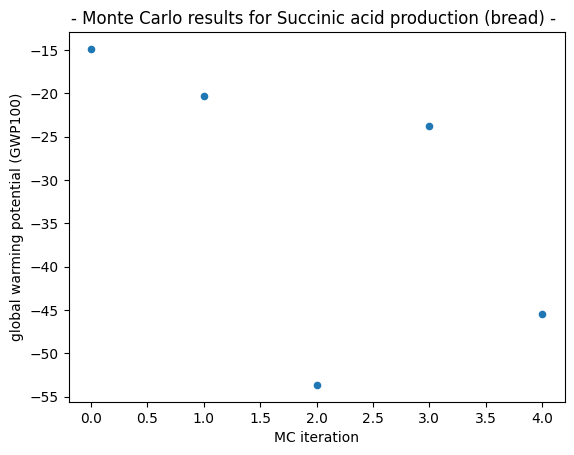

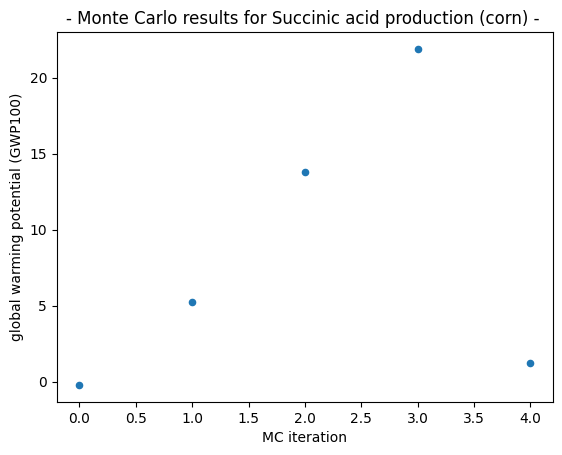

In [6]:
if recalculate_MC == True:
    for model in models:
        single_score = get_LCA_scores(model, scenario_name)
        get_MCLCA_scores(model, single_score, iterations, mc_type, scenario_name)

t = -4.630252705759331
p = 3.27e-03
stat_MW = 0.0
p_PS = 7.94e-03
stat_KS = 1.0
p_KS = 7.94e-03
*** Welch's t-test
stat = -4.63
p = 3.27e-03
*** Mann-Whitney U test
stat = 0.00
p = 7.94e-03
*** Kolmogorov-Smirnov test
stat = 1.00
p = 7.94e-03


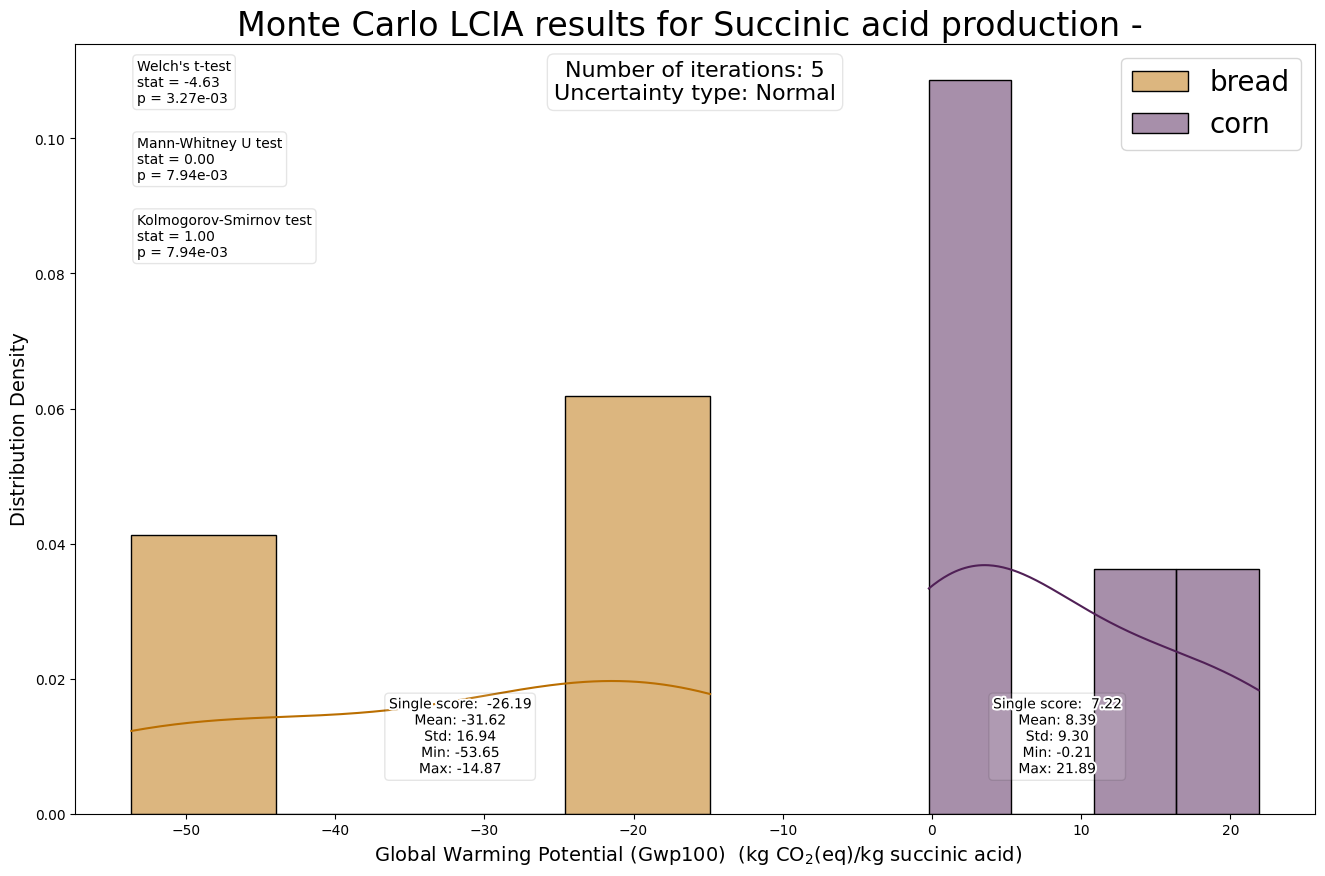

  _________________________________________________
 /                                                 \
| ==== Results for Monte Carlo analysis ====        |
| ***  bread @ global warming potential (GWP100) @  |
| -26.19kg CO2eq / kg  ***                          |
| count, 5.0                                        |
| mean, -31.620720502819324                         |
| std, 16.93677727953723                            |
| min, -53.64902428429261                           |
| 25%, -45.49091697489187                           |
| 50%, -23.76553890257856                           |
| 75%, -20.325913050184223                          |
| max, -14.872209302149354                          |
 \                                                 /
                                                   \
                                                    \
                                                     \
                                                      \
                              

In [7]:
import cowsay 
if revisualise == True:
    df = vis.plot_MC_results(mc_type, scenario_name)
    dic = df.describe().to_dict()

    results_list = []
    results_list.append("==== Results for Monte Carlo analysis ====")
    for key in dic.keys():
        results_list.append("\n***  "  + key + "kg CO2eq / kg  ***")
        for k, v in dic[key].items():
            results_list.append(f"{k}, {v}")
        print(cowsay.turtle('\n'.join(results_list)))
 


# STATS_ARRAYS DISTRIBUTION IDS
#  0: stats_arrays.distributions.undefined.UndefinedUncertainty,
#  1: stats_arrays.distributions.undefined.NoUncertainty,
#  2: stats_arrays.distributions.lognormal.LognormalUncertainty,
#  3: stats_arrays.distributions.normal.NormalUncertainty,
#  4: stats_arrays.distributions.geometric.UniformUncertainty,
#  5: stats_arrays.distributions.geometric.TriangularUncertainty,
#  6: stats_arrays.distributions.bernoulli.BernoulliUncertainty,
#  7: stats_arrays.distributions.discrete_uniform.DiscreteUniform,
#  8: stats_arrays.distributions.weibull.WeibullUncertainty,
#  9: stats_arrays.distributions.gamma.GammaUncertainty,
#  10: stats_arrays.distributions.beta.BetaUncertainty,
#  11: stats_arrays.distributions.extreme.GeneralizedExtremeValueUncertainty,
#  12: stats_arrays.distributions.student.StudentsTUncertaint